# **Tests for Numerical CLUE**

In this notebook we are going to test out (with several examples) how the implementation of numerical CLUE works on different type of examples:

* Basic polynomial examples (for shake of testing the code)
* Rational examples (this will be an improvement from the ERODE current implementation)

For each of the models we are going to perform several tests:

- With the **exact model**: 
  * We increase the $\delta$ threshold slowly until we aggregate everything together. This produces two different graphical values:
    1. Given $\delta$, the number of reduced species. 
    2. Given $\delta$, the error of the observed species.
- We **perturb the model** using a small random noise:
  * We check if we manage to obtain the original reduction for some $\delta$.
  * We check if the observed quantity is close to the **true** value.
  
Since we need to perform similar runs for different models, the notebook will start with a section dedicated to set up generic functions to run each of the tests. Then, further sections will run these generic functions for specific models with small comments on the results.


In [35]:
## Adding appropriate paths for loading examples
import sys, os

sys.path.insert(0,"./../") # clue and models are here
sys.path.insert(0, "./../tests") # eramples is here

from clue import *
from clue.simulations import *
from examples.examples_data import *
from math import ceil, log10
from numpy import array, matmul
from numpy.linalg import pinv, norm, det
from scipy.optimize._optimize import OptimizeResult
from typing import Collection

import logging

logger = logging.getLogger("clue")
logger.setLevel(logging.WARNING)

## 1. Generic testing functions

In [36]:
def run_exact_test(example_name: str, # argument for name
                   init_delta: float = 0.0, increase_delta: float = 0.1, # arguments for evolution on delta
                   t0: float = 0.0, t1: float = 1.0, x0: Collection[float] = None, tstep: float = None,  # arguments for simulations
                   measure="l2avg" # measure to be use for errors
):
    ## Processing the input
    increase_log10 = log10(increase_delta)
    if increase_log10 < 0: # the increase is smaller than 1
        rounding = ceil(-increase_log10)
    else: # the increase is bigger than 1
        rounding = 2
    
    ## Getting the example
    example = get_example(example_name)
    system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read)
    
    ## Creating observables
    observables = [[SparsePolynomial.from_string(s, system.variables, system.field) for s in obs_set] for obs_set in example.observables]
    
    ## Computing the true lumpings for each observable
    logger.info("[exact_test] Computing the exact lumpings...")
    lumped_systems = [system.lumping(obs_polys, method=example.matrix, print_system=False,print_reduction=False) for obs_polys in observables]
    logger.info(f"[exact_test]  + Done! {[sys.size for sys in lumped_systems]}")
    
    logger.info("[exact_test] Computing the numerical lumpings...")
    delta = init_delta; increase = increase_delta; key = None
    numerical_lumpings = dict()
    while len(numerical_lumpings) == 0 or any(numerical_lumpings[key][i].size > len(example.observables[i]) for i in range(len(numerical_lumpings[key]))):
        key = round(delta, rounding)
        logger.info(f"[exact_test]  - Running case with {delta=}...")
        num_system = FODESystem(file=example.path_model(), parser=example.read, lumping_subspace=NumericalSubspace, lumping_subspace_kwds={"delta": delta})
        numerical_lumpings[key] = [num_system.lumping(obs_polys, method=example.matrix, print_system=False, print_reduction=False) for obs_polys in observables]
        logger.info(f"[exact_test]  + Done!! {[sys.size for sys in numerical_lumpings[key]]}")
        delta += increase
    logger.info("[exact_test] Done numerical lumpings")
    
    ## Producing the graph for size reduction
    deltas = list(numerical_lumpings.keys())
    names = [str(obs_polys) for obs_polys in observables]
    sizes = [[numerical_lumpings[delta][i].size for delta in deltas] for i in range(len(names))]
    delta_vs_size = OptimizeResult(t=array(deltas), y=array(sizes)/num_system.size, names=names, success=True)
    
    ## producing the simulations
    if t0 > t1: t0,t1 = t1,t0
    x0 = [system.ic.get(v, 0) for v in system.variables] if x0 is None else x0; x0 = array(x0)
    tstep = (t1-t0)/200 if tstep is None else tstep
    
    logger.info("[exact_test] Computing simulation for real system...")
    real_simulation = system.simulate(t0, t1, x0, tstep)
    observables_matrices = [SparseRowMatrix.from_vectors([poly.linear_part_as_vec() for poly in obs]) for obs in observables]
    real_obs_alone = [apply_matrix(real_simulation, O) for O in observables_matrices]
    
    numerical_errors = dict()
    for delta in numerical_lumpings:
        logger.info(f"[exact_test]  - Computing simulation for {delta=}...")
        errors = []
        for i, O in enumerate(observables_matrices):
            lsystem = numerical_lumpings[delta][i]
            lx0 = matmul(lsystem.lumping_matrix.to_numpy(), x0)
            numerical_sim = lsystem.simulate(t0,t1,lx0,tstep)
            numerical_sim = apply_matrix(numerical_sim, O.matmul(lsystem._subspace.pinv()))
            comparison = compare_simulations(real_obs_alone[i], numerical_sim, measures=measure)
            errors.append(norm(comparison[1][0]))
        numerical_errors[delta] = errors
        
    errors = array([[numerical_errors[delta][i] for delta in numerical_errors] for i in range(len(names))])
    delta_vs_error_obs = OptimizeResult(t=array(deltas), y=array(errors), names=names, success=True)
        
        
    return (system, lumped_systems, numerical_lumpings), (delta_vs_size, delta_vs_error_obs)

In [37]:
(system, lumped, numerical), graphs = run_exact_test("ProteinPhosphorylation[2]", 1.5, 0.1, t0=0.0, t1=0.00125)

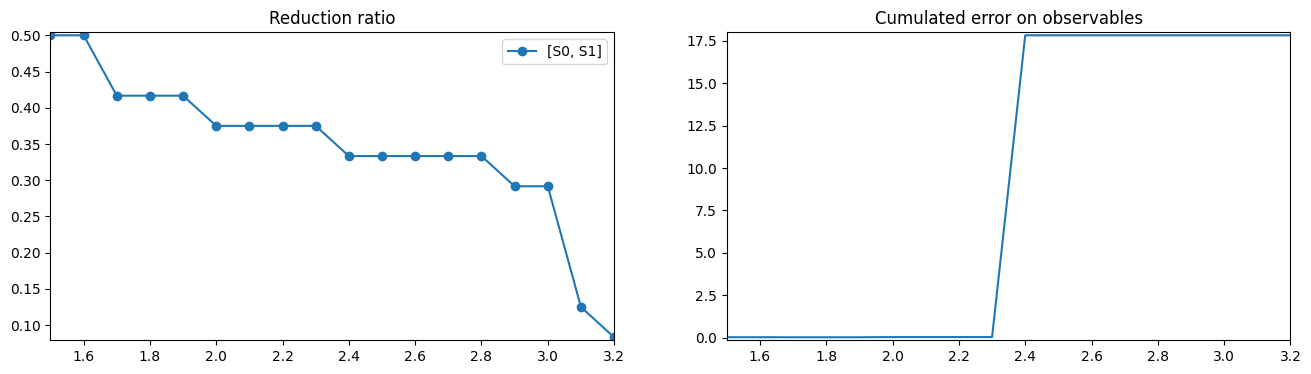

In [38]:
create_figure(graphs, title=["Reduction ratio", "Cumulated error on observables"], format=["-o", "-"]);